# **Project 2 - Diabetes**
by Martin Tschechne, Han Bai, Nora Moser

In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from xgboost import XGBClassifier, plot_tree

## **Exploratory Data Analysis & Feature Engineering**

In [120]:
data_train = pd.read_csv('../data/raw/10k_diabetes/diab_train.csv')
data_val = pd.read_csv('../data/raw/10k_diabetes/diab_validation.csv')
data_test = pd.read_csv('../data/raw/10k_diabetes/diab_test.csv')

For data exploration we look at the whole data set before we split again ...

In [121]:
data_train['type'] = 'train'
data_val['type'] = 'val'
data_test['type'] = 'test'
data = pd.concat([data_train,data_val,data_test],ignore_index=True)

In [122]:
data.T.head(50)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
Unnamed: 0,9011,9569,6090,4282,9084,1776,797,413,8150,5317,...,996,8380,190,4132,1338,1262,9135,1339,3040,5437
race,AfricanAmerican,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Asian,...,Hispanic,Caucasian,Caucasian,Caucasian,Caucasian,?,Caucasian,AfricanAmerican,AfricanAmerican,Caucasian
gender,Male,Female,Female,Female,Male,Female,Male,Female,Male,Male,...,Female,Male,Female,Male,Female,Male,Male,Male,Male,Female
age,[60-70),[70-80),[80-90),[50-60),[80-90),[70-80),[60-70),[60-70),[20-30),[80-90),...,[30-40),[50-60),[80-90),[80-90),[40-50),[40-50),[80-90),[40-50),[50-60),[80-90)
weight,?,?,?,?,?,?,[75-100),?,?,?,...,?,?,?,?,?,?,?,?,?,?
admission_type_id,Emergency,Elective,Urgent,Emergency,Elective,Emergency,Elective,Emergency,Emergency,Urgent,...,Emergency,Urgent,Emergency,Emergency,Elective,Urgent,Not Available,Elective,Emergency,Elective
discharge_disposition_id,Discharged to home,NaN,Discharged/transferred to SNF,Discharged to home,NaN,Discharged/transferred to SNF,Discharged/transferred to ICF,Discharged to home,Discharged to home,Discharged/transferred to another short term h...,...,Discharged to home,Discharged to home,Discharged to home,Expired,NaN,Discharged to home,Discharged/transferred to SNF,NaN,Discharged to home,Discharged/transferred to another rehab fac in...
admission_source_id,Emergency Room,Physician Referral,Emergency Room,Emergency Room,Physician Referral,Emergency Room,Transfer from another health care facility,Transfer from a hospital,Emergency Room,Emergency Room,...,Emergency Room,Emergency Room,Emergency Room,Emergency Room,Transfer from a hospital,Transfer from a hospital,NaN,Physician Referral,Emergency Room,Physician Referral
time_in_hospital,4,1,2,4,13,3,5,3,2,1,...,6,3,12,7,10,1,6,4,2,1
payer_code,MC,?,MC,DM,?,?,MC,MC,?,SP,...,?,HM,MC,MC,?,UN,?,?,?,CM


We have categorical (e.g. gender), numerical (e.g. num_lab_procedures), ordinal features (e.g. ethnicity) and text (e.g. diag_1_desc)  
Lets take a look at our label distribution and No Information Rate. Later we will ise this value to compare our models with.

In [123]:
classes, counts = np.unique(data.readmitted.values, return_counts=True)
nir = np.max(counts/len(data))
print(f"Class {classes[0]}: {counts[0]*100/np.sum(counts)} %, Class {classes[1]}: {counts[1]*100/np.sum(counts)}%")
print(f"NIR: {nir * 100} %")

Class 0: 60.35 %, Class 1: 39.65%
NIR: 60.35 %


Have a look at missing values ...

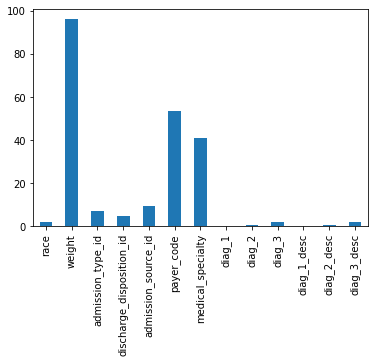

In [124]:
data.replace('?',np.nan,inplace=True)
nans = pd.Series(data.isna().sum()*100/len(data))
nans[nans != 0.0].plot.bar()

weight, payer_code and medical_specialty have over 40% missing values, thus we are dropping these features.

In [125]:
to_drop = ['weight','payer_code','medical_specialty','Unnamed: 0']
data.drop(to_drop,axis=1,inplace=True)

In [126]:
data[data['diag_1']=='250.01']['diag_1_desc']

395     Diabetes mellitus without mention of complicat...
1076    Diabetes mellitus without mention of complicat...
2184    Diabetes mellitus without mention of complicat...
3604    Diabetes mellitus without mention of complicat...
6546    Diabetes mellitus without mention of complicat...
7055    Diabetes mellitus without mention of complicat...
7364    Diabetes mellitus without mention of complicat...
9477    Diabetes mellitus without mention of complicat...
Name: diag_1_desc, dtype: object

Textual descriptions of ICD9 codes are the same for a specific code.

In [127]:
diag_text = data[['diag_1_desc','diag_2_desc','diag_3_desc']]
data.drop(['diag_1_desc','diag_2_desc','diag_3_desc'],axis=1,inplace=True)

Let's look at how many unique values we have in each feature:

In [128]:
to_drop = []
for k in data.keys():
    print(f"key: {k}: {len(data[k].unique())}")
    if len(data[k].unique()) == 1:
        to_drop.append(k)

key: race: 6
key: gender: 2
key: age: 10
key: admission_type_id: 7
key: discharge_disposition_id: 22
key: admission_source_id: 11
key: time_in_hospital: 14
key: num_lab_procedures: 108
key: num_procedures: 7
key: num_medications: 68
key: number_outpatient: 23
key: number_emergency: 12
key: number_inpatient: 11
key: diag_1: 458
key: diag_2: 430
key: diag_3: 461
key: number_diagnoses: 9
key: max_glu_serum: 4
key: A1Cresult: 4
key: metformin: 4
key: repaglinide: 4
key: nateglinide: 4
key: chlorpropamide: 3
key: glimepiride: 4
key: acetohexamide: 1
key: glipizide: 4
key: glyburide: 4
key: tolbutamide: 2
key: pioglitazone: 4
key: rosiglitazone: 4
key: acarbose: 3
key: miglitol: 4
key: troglitazone: 1
key: tolazamide: 2
key: examide: 1
key: citoglipton: 1
key: insulin: 4
key: glyburide.metformin: 4
key: glipizide.metformin: 2
key: glimepiride.pioglitazone: 1
key: metformin.rosiglitazone: 1
key: metformin.pioglitazone: 1
key: change: 2
key: diabetesMed: 2
key: readmitted: 2
key: type: 3


We see some features contain only one unique value, we drop those since they do not provide any useful information.

In [129]:
to_drop

['acetohexamide',
 'troglitazone',
 'examide',
 'citoglipton',
 'glimepiride.pioglitazone',
 'metformin.rosiglitazone',
 'metformin.pioglitazone']

In [130]:
data.drop(to_drop,axis=1,inplace=True)

In [131]:
data.keys()

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin',
       'glyburide.metformin', 'glipizide.metformin', 'change', 'diabetesMed',
       'readmitted', 'type'],
      dtype='object')

In [132]:
data.isna().sum()

race                        221
gender                        0
age                           0
admission_type_id           721
discharge_disposition_id    469
admission_source_id         936
time_in_hospital              0
num_lab_procedures            0
num_procedures                0
num_medications               0
number_outpatient             0
number_emergency              0
number_inpatient              0
diag_1                        2
diag_2                       59
diag_3                      208
number_diagnoses              0
max_glu_serum                 0
A1Cresult                     0
metformin                     0
repaglinide                   0
nateglinide                   0
chlorpropamide                0
glimepiride                   0
glipizide                     0
glyburide                     0
tolbutamide                   0
pioglitazone                  0
rosiglitazone                 0
acarbose                      0
miglitol                      0
tolazami

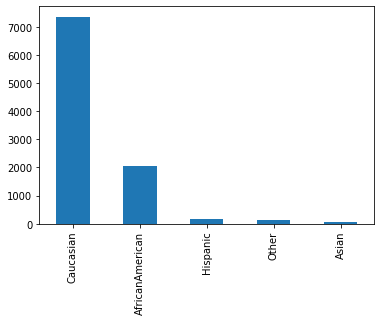

In [133]:
data.race.value_counts().plot.bar()

In [134]:
data.replace(np.nan,'?',inplace=True)

Impute race with median 'Caucasian'

In [135]:
data['race'].mode()

0    Caucasian
dtype: object

In [136]:
race_dict = {r:r for r in data['race'].unique()}
race_dict['?'] = 'Caucasian'
print(race_dict)
data['race'] = data.race.apply(lambda x: race_dict[x])

{'AfricanAmerican': 'AfricanAmerican', 'Caucasian': 'Caucasian', 'Asian': 'Asian', 'Other': 'Other', 'Hispanic': 'Hispanic', '?': 'Caucasian'}


In [137]:
for k in data.keys():
    print(f"key: {k}: {data[k].unique()}\n")

key: race: ['AfricanAmerican' 'Caucasian' 'Asian' 'Other' 'Hispanic']

key: gender: ['Male' 'Female']

key: age: ['[60-70)' '[70-80)' '[80-90)' '[50-60)' '[20-30)' '[40-50)' '[30-40)'
 '[10-20)' '[90-100)' '[0-10)']

key: admission_type_id: ['Emergency' 'Elective' 'Urgent' '?' 'Not Available' 'Not Mapped'
 'Newborn']

key: discharge_disposition_id: ['Discharged to home' '?' 'Discharged/transferred to SNF'
 'Discharged/transferred to ICF'
 'Discharged/transferred to another short term hospital' 'Not Mapped'
 'Discharged/transferred to home with home health service'
 'Discharged/transferred to another rehab fac including rehab units of a hospital.'
 'Discharged/transferred to another  type of inpatient care institution'
 'Discharged/transferred to a long term care hospital.' 'Expired'
 'Admitted as an inpatient to this hospital' 'Left AMA' 'Hospice / home'
 'Discharged/transferred to home under care of Home IV provider'
 'Hospice / medical facility'
 'Discharged/transferred/referred to a

Convert age classes into numerical values ...

In [138]:
age_dict = dict()
for i in range(10):
    age_dict[f"[{10*i}-{10*(i+1)})"] = 10*(i+0.5)
print(age_dict)

{'[0-10)': 5.0, '[10-20)': 15.0, '[20-30)': 25.0, '[30-40)': 35.0, '[40-50)': 45.0, '[50-60)': 55.0, '[60-70)': 65.0, '[70-80)': 75.0, '[80-90)': 85.0, '[90-100)': 95.0}


In [139]:
data['age'] = data.age.apply(lambda x: age_dict[x])

In [140]:
data.age.head()

0    65.0
1    75.0
2    85.0
3    55.0
4    85.0
Name: age, dtype: float64

Look at distributions of other features given the readmitted class ...

In [141]:
obj_keys = data.select_dtypes('object').keys().tolist()
obj_keys = [ok for ok in obj_keys if ok not in ['admission_type_id', 'discharge_disposition_id','admission_source_id', 'diag_1', 'diag_2', 'diag_3']]
print(obj_keys)

['race', 'gender', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin', 'glyburide.metformin', 'glipizide.metformin', 'change', 'diabetesMed', 'type']


/home/martin/miniconda3/envs/ml4h-p1-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


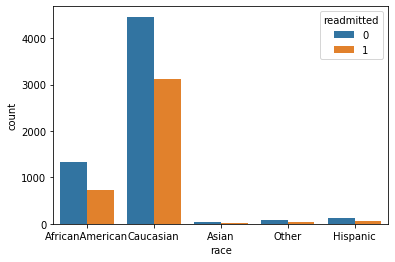

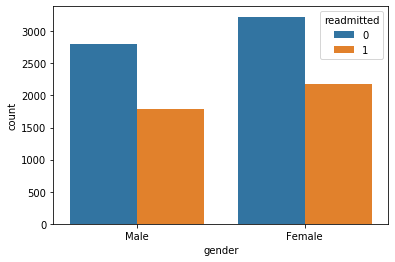

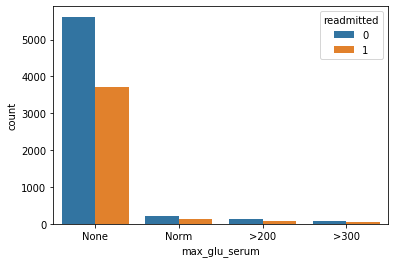

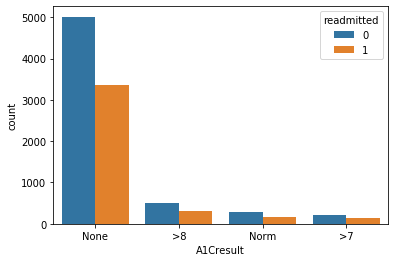

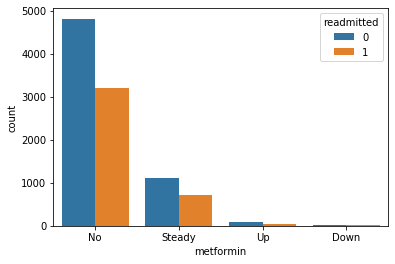

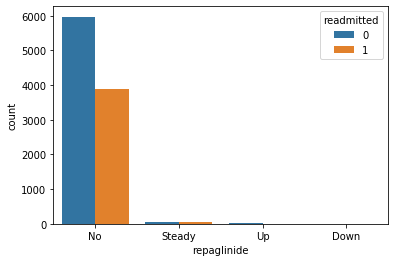

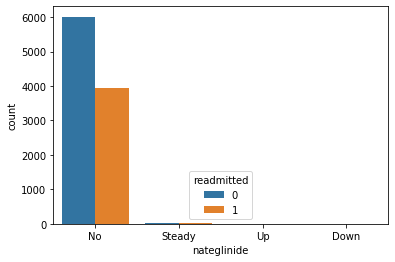

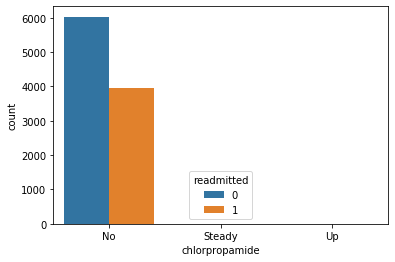

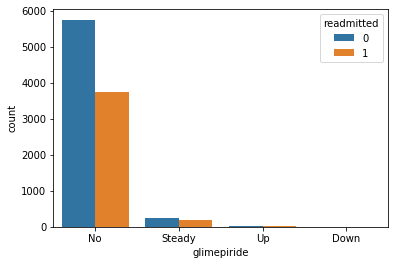

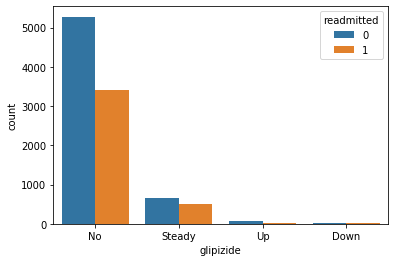

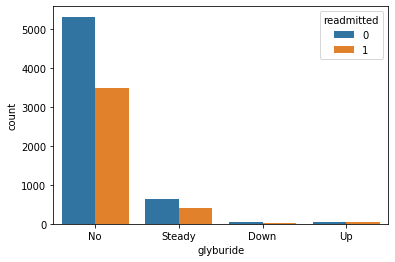

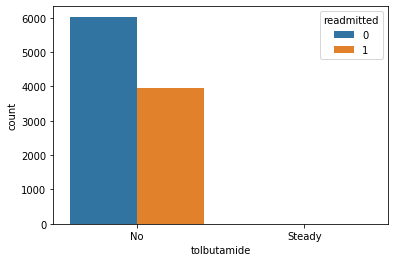

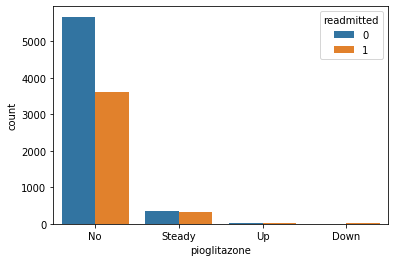

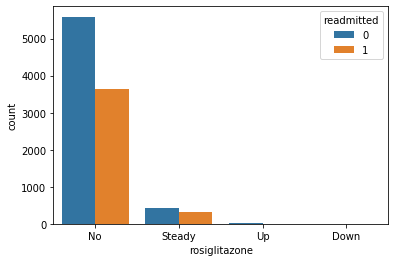

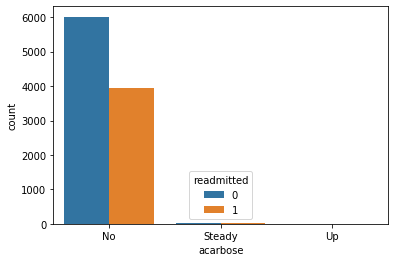

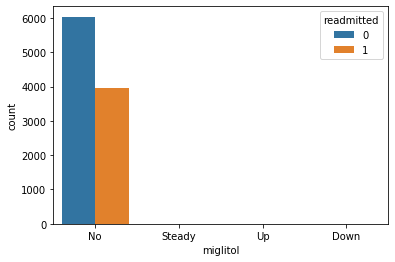

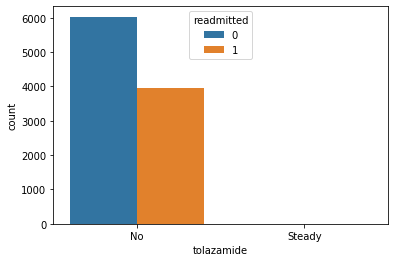

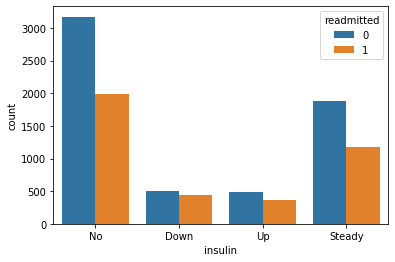

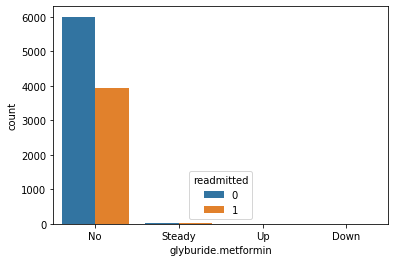

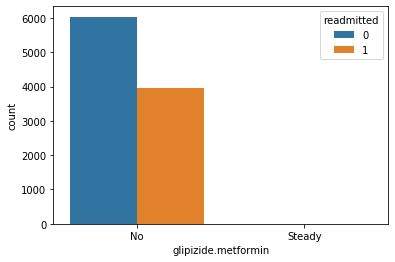

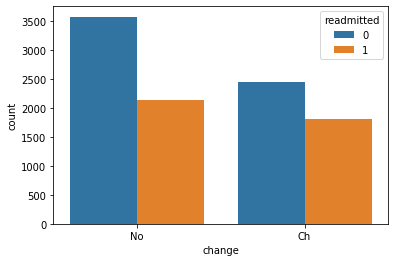

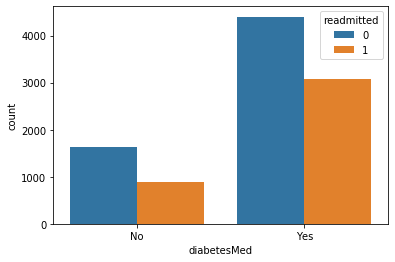

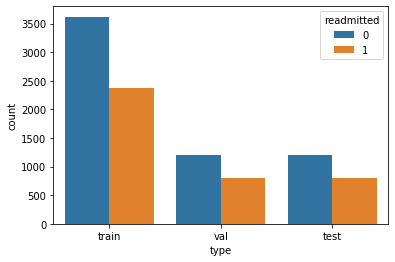

In [142]:
for k in obj_keys:
    plt.figure()
    sns.countplot(x=k,hue='readmitted',data=data)

Convert other categorical features into numericals ...

In [143]:
glu = {'None': 0,
       'Norm': 100,
       '>200': 200,
       '>300': 300 }
A1C = {'None':0,
      '>8':8,
      'Norm':5,
      '>7':7}
med = {'No':-20,
       'Steady':0,
       'Up':10,
       'Down':-10}
diaMed = {'No':-1,'Yes':1}
change = {'No':-1,'Ch':1}

In [144]:
data.max_glu_serum = data.max_glu_serum.apply(lambda x: glu[x])
data.A1Cresult = data.A1Cresult.apply(lambda x: A1C[x])
data.change = data.change.apply(lambda x: change[x])
data.diabetesMed = data.diabetesMed.apply(lambda x: diaMed[x])
for medication in ['metformin','repaglinide','nateglinide',
                    'chlorpropamide','glimepiride','glipizide','glyburide',
                    'tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol',
                    'tolazamide','insulin','glyburide.metformin','glipizide.metformin']:
    data[medication] = data[medication].apply(lambda x : med[x])

Look at distributions of numerical features ...

In [145]:
num = data.select_dtypes('number').keys()
num = ['readmitted', 'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications']

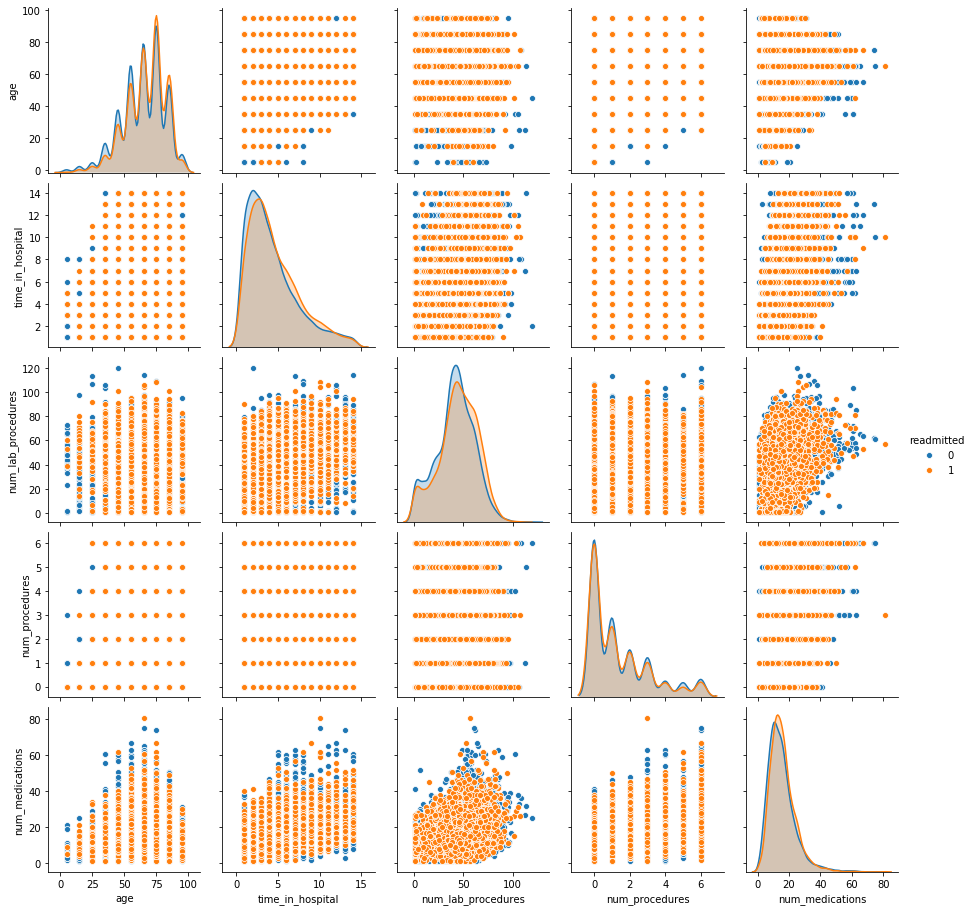

In [146]:
sns.pairplot(data[num],hue='readmitted')

As in the original paper, we group ICD9-codes into categories

In [147]:
def convert_icd9_codes(code):
    if '250.' in code:
        return 'diabetes'
    elif code[0] == 'E' or code[0] == 'V' or code == '?':
        return 'other'
    else:
        code = int(code)
        if code >= 390 and code <= 459 or code == 785:
            return 'circulatory'
        elif code >= 460 and code <= 519 or code == 786:
            return 'respiratory'
        elif code >= 520 and code <= 579 or code == 787:
            return 'degistive'
        elif code >= 800 and code <= 999:
            return 'injury'
        elif code >= 710 and code <= 739:
            return 'musculoskeletal'
        elif code >= 580 and code <= 629 or code == 788:
            return 'genitourinary'
        elif code >= 140 and code <= 239:
            return 'neoplasms'
        else:
            return 'other'

In [148]:
for diag in ['diag_1','diag_2','diag_3']:
    data[diag]=data[diag].apply(lambda x: convert_icd9_codes(x))

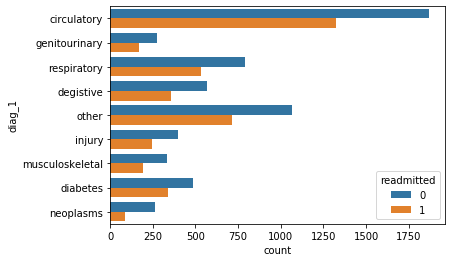

In [149]:
data['diag_1'].unique()
sns.countplot(y='diag_1',hue='readmitted',data=data,orient='h')

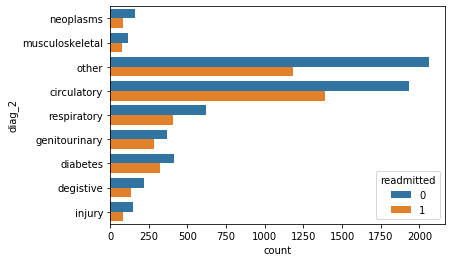

In [150]:
data['diag_2'].unique()
sns.countplot(y='diag_2',hue='readmitted',data=data,orient="h")

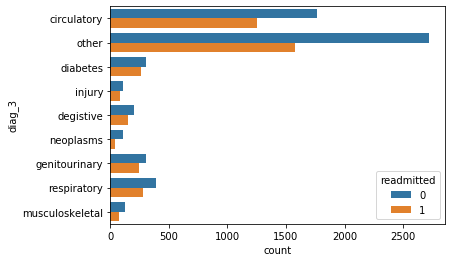

In [151]:
data['diag_3'].unique()
sns.countplot(y='diag_3',hue='readmitted',data=data,orient='h')

In [152]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 39 columns):
race                        10000 non-null object
gender                      10000 non-null object
age                         10000 non-null float64
admission_type_id           10000 non-null object
discharge_disposition_id    10000 non-null object
admission_source_id         10000 non-null object
time_in_hospital            10000 non-null int64
num_lab_procedures          10000 non-null int64
num_procedures              10000 non-null int64
num_medications             10000 non-null int64
number_outpatient           10000 non-null int64
number_emergency            10000 non-null int64
number_inpatient            10000 non-null int64
diag_1                      10000 non-null object
diag_2                      10000 non-null object
diag_3                      10000 non-null object
number_diagnoses            10000 non-null int64
max_glu_serum               10000 non-null int64


Split data again into train, validation and test set

In [153]:
train = data[data.type=='train']
y_train = train['readmitted']
train.drop(['readmitted','type'],axis=1,inplace=True)

val = data[data.type=='val']
y_val = val['readmitted']
val.drop(['readmitted','type'],axis=1,inplace=True)

test = data[data.type=='test']
y_test = test['readmitted']
test.drop(['readmitted','type'],axis=1,inplace=True)

/home/martin/miniconda3/envs/ml4h-p1-env/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [154]:
data_type = data['type']
readmitted = data['readmitted']
data.drop(['type','readmitted'],axis=1,inplace=True)

Make remaining features ordinal 

In [155]:
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(data)
train = ordinal_encoder.transform(train)
val = ordinal_encoder.transform(val)
test = ordinal_encoder.transform(test)

Normalize data

In [156]:
scaler = StandardScaler()
train = scaler.fit_transform(np.concatenate((train,val),axis=0))
test = scaler.transform(test)

In [157]:
y_train = np.concatenate((y_train,y_val),axis=0)

## **NLP for Diagnose**  

In [158]:
diag_text.head()

,diag_1_desc,diag_2_desc,diag_3_desc
0,Acute pericarditis in diseases classified else...,Secondary malignant neoplasm of kidney,"Congestive heart failure, unspecified"
1,Malignant essential hypertension,"Spinal stenosis, unspecified region",Diabetes mellitus without mention of complicat...
2,"Urinary tract infection, site not specified",Streptococcus infection in conditions classifi...,"Congestive heart failure, unspecified"
3,"Respiratory abnormality, unspecified","Hypertensive chronic kidney disease, malignant...",Diabetes mellitus without mention of complicat...
4,Coronary atherosclerosis of unspecified type o...,"Chronic airway obstruction, not elsewhere clas...",Malignant essential hypertension


In [159]:
diag_text.isna().sum()

diag_1_desc      2
diag_2_desc     59
diag_3_desc    208
dtype: int64

In [160]:
diag_text.fillna('?',inplace=True)

/home/martin/miniconda3/envs/ml4h-p1-env/lib/python3.7/site-packages/pandas/core/frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [161]:
diag_text.isna().sum()

diag_1_desc    0
diag_2_desc    0
diag_3_desc    0
dtype: int64

In [162]:
corpus = diag_text['diag_1_desc'].tolist()+diag_text['diag_2_desc'].tolist()+diag_text['diag_3_desc'].tolist()
y_diag = np.array(data_type.tolist()+data_type.tolist()+data_type.tolist())
y_diag.shape

(30000,)

In [163]:
corpus = [c.replace(',','') for c in corpus]
corpus = [c.replace('/',' ') for c in corpus]

We convert the textual features into a vector representation in order to work with them. For this we use TF-IDF vectorization. 2- and 3-grams are choosen since single words are less meaningful in our medical contenxt as combinations of words, e.g. "heart" is less informative than "heart failure".

In [164]:
tfidf_vec = TfidfVectorizer(stop_words='english',ngram_range=(2,3),max_features=200,min_df=10,max_df=0.9)

In [165]:
X = tfidf_vec.fit_transform(corpus)
X.shape

(30000, 200)

In [166]:
diag_train = X[(y_diag == 'train'),:].todense()
diag_val = X[(y_diag == 'val'),:].todense()
diag_train = np.concatenate([diag_train,diag_val],axis=0)
diag_test = X[(y_diag == 'test'),:].todense()

In [167]:
diag_train.shape, y_train.shape

((24000, 200), (8000,))

## **Feature Importance & Selection**
First we look at the feature importance of numerical / categorical with XGBoost

In [168]:
%%time
model = XGBClassifier(base_score=0.6035,booster='gbtree',max_depth=7,n_jobs=-1,random_state=42, n_estimators=100,metric='auc',subsample=0.7)
model.fit(train, y_train)

CPU times: user 3.94 s, sys: 29.8 ms, total: 3.97 s
Wall time: 1.08 s


XGBClassifier(base_score=0.6035, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7, metric='auc',
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [169]:
feat_import = sorted(zip(model.feature_importances_,data.keys().tolist(), np.int8(np.linspace(0,len(data.keys()),len(data.keys())+1))),reverse=True)

Top-10 important features:

In [170]:
feat_import[:10]

[(0.08933195, 'number_inpatient', 12),
 (0.040410183, 'discharge_disposition_id', 4),
 (0.040296707, 'pioglitazone', 27),
 (0.039312083, 'number_emergency', 11),
 (0.038428407, 'number_diagnoses', 16),
 (0.036689784, 'repaglinide', 20),
 (0.03609399, 'glyburide.metformin', 33),
 (0.03348759, 'number_outpatient', 10),
 (0.032172557, 'admission_source_id', 5),
 (0.031897582, 'glimepiride', 23)]

Top-10 unimfortant features:

In [171]:
feat_import[-10:]

[(0.024675423, 'insulin', 32),
 (0.02445555, 'diag_3', 15),
 (0.024125557, 'diag_2', 14),
 (0.023941364, 'diabetesMed', 36),
 (0.020885503, 'acarbose', 29),
 (0.0, 'tolbutamide', 26),
 (0.0, 'tolazamide', 31),
 (0.0, 'miglitol', 30),
 (0.0, 'glipizide.metformin', 34),
 (0.0, 'chlorpropamide', 22)]

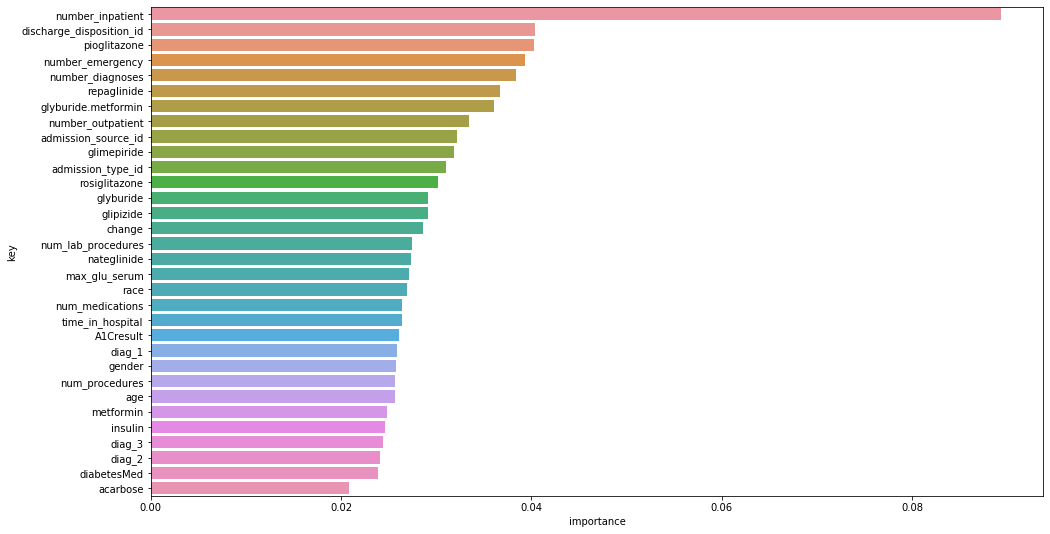

In [172]:
importance, key, num_idx = zip(*feat_import)
non_zero = np.array(importance) != 0
plot_df = pd.DataFrame({'importance':np.array(importance)[non_zero],
             'key':np.array(key)[non_zero],
             'idx':np.array(num_idx)[non_zero]})
plt.figure(figsize=(16,9))
sns.barplot(y='key',x='importance',data=plot_df)
plt.savefig('./visualization/num-cat-feature-importance.png',dpi=100)

We see that the number of inpatient stays has the most importance followed by discharge_disposition_id, number emergencies and number disgnoses

In [173]:
%%time
model = XGBClassifier(base_score=0.6035,booster='gbtree',max_depth=7,n_jobs=-1,random_state=42, n_estimators=100,metric='auc',subsample=0.7)
model.fit(diag_train, np.concatenate([y_train,y_train,y_train],axis=0))

CPU times: user 37.8 s, sys: 130 ms, total: 38 s
Wall time: 9.89 s


XGBClassifier(base_score=0.6035, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7, metric='auc',
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [174]:
text_import = sorted(zip(model.feature_importances_,tfidf_vec.get_feature_names(), np.int32(np.linspace(0,len(tfidf_vec.get_feature_names()),len(tfidf_vec.get_feature_names())+1))),reverse=True)

Top-10 important text features:

In [175]:
text_import[:10]

[(0.02545916, 'ketoacidosis type juvenile', 100),
 (0.025399944, 'mitral valve disorders', 125),
 (0.025028588, 'failure unspecified', 76),
 (0.023630848, 'episode care', 71),
 (0.022475729, 'heart failure', 81),
 (0.019731952, 'acute pancreatitis', 9),
 (0.01882434, 'cerebral thrombosis', 32),
 (0.018562406, 'malignant neoplasm', 110),
 (0.018423053, 'acute kidney', 5),
 (0.018292375, 'unspecified type stated', 190)]

10 unimportant text features:

In [176]:
text_import[-10:]

[(0.0, 'calculus gallbladder acute', 23),
 (0.0, 'calculus gallbladder', 22),
 (0.0, 'atherosclerosis unspecified type', 20),
 (0.0, 'anterolateral wall episode', 16),
 (0.0, 'anterolateral wall', 15),
 (0.0, 'alcohol abuse unspecified', 13),
 (0.0, 'alcohol abuse', 12),
 (0.0, 'airway obstruction classified', 11),
 (0.0, 'acute myocardial infarction', 8),
 (0.0, 'acute kidney failure', 6)]

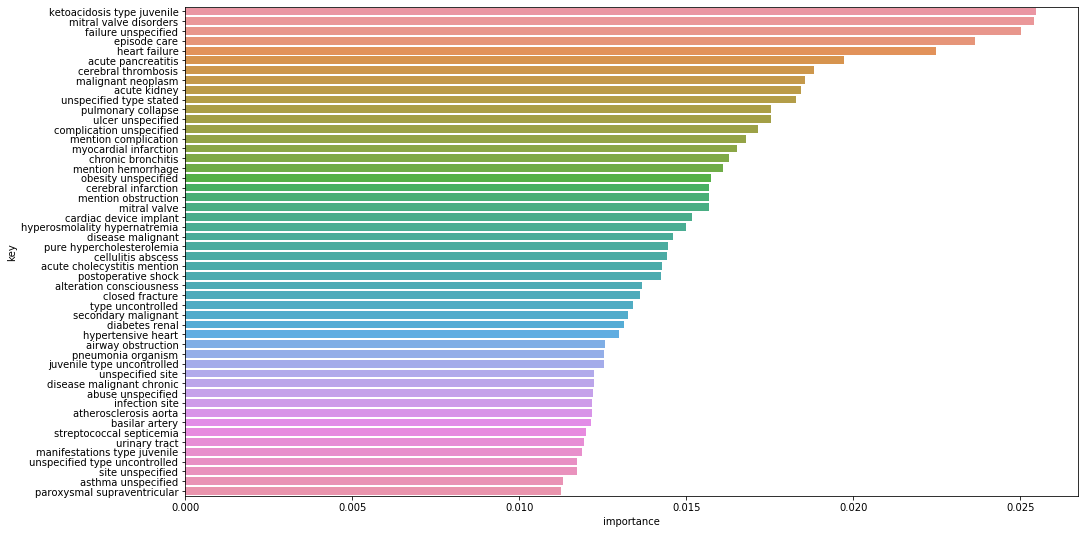

In [177]:
importance, key, idx = zip(*text_import)
threshold = np.array(importance) >= 0.01
plot_df = pd.DataFrame({'importance':np.array(importance)[threshold][:50],
             'key':np.array(key)[threshold][:50],
             'idx':np.array(idx)[threshold][:50]})
plt.figure(figsize=(16,9))
sns.barplot(y='key',x='importance',data=plot_df)
plt.savefig('./visualization/text-feature-importance.png',dpi=100)

Specific disgnoses indicate a higher chance for readmittance. Those are linked to heart diseases or organ failure.

## Modelling  
We try a plethora of different models to see how they perform ...

In [184]:
models = [('SVM linear',SVC(kernel='linear',random_state=42)),
         ('SVM rbf',SVC(kernel='rbf',random_state=42)),
         ('SVM poly',SVC(kernel='poly',random_state=42)),
         ('Logistic Regression', LogisticRegression(random_state=42,n_jobs=-1)),
         ('Random Forest', RandomForestClassifier(random_state=42)),
         ('XGBoost', XGBClassifier(base_score=0.6035,booster='gbtree',max_depth=7,n_jobs=-1,random_state=42, n_estimators=100,metric='auc',subsample=0.7)),
         ('MLP', MLPClassifier(random_state=42, early_stopping=True)),
         ('Naive Bayes', GaussianNB(priors=[nir, 1.-nir]))]

First we compare numerical/categorical features against textual features:

In [185]:
%%time
for d, X, X_test in [('num/cat features',train, test),
                     ('text features',diag_train.reshape((8000,-1)),diag_test.reshape((2000,-1)))]:
    print(10*':::')
    print(d+':')
    for name, model in models:
        print(10*'---')
        print(name +':')
        model.fit(X,y_train)
        test_preds = model.predict(X_test)
        print(f"F1: {f1_score(y_test,test_preds,average='micro'):.3f}")
        print(f"AUROC: {roc_auc_score(y_test,test_preds):.3f}")
    print('\n')

::::::::::::::::::::::::::::::
num/cat features:
------------------------------
SVM linear:
F1: 0.626
AUROC: 0.546
------------------------------
SVM rbf:
F1: 0.647
AUROC: 0.584
------------------------------
SVM poly:
F1: 0.632
AUROC: 0.558
------------------------------
Logistic Regression:
F1: 0.629
AUROC: 0.568
------------------------------
Random Forest:
F1: 0.658
AUROC: 0.609
------------------------------
XGBoost:
F1: 0.660
AUROC: 0.619
------------------------------
MLP:
F1: 0.633
AUROC: 0.582
------------------------------
Naive Bayes:
F1: 0.625
AUROC: 0.550


::::::::::::::::::::::::::::::
text features:
------------------------------
SVM linear:
F1: 0.597
AUROC: 0.500
------------------------------
SVM rbf:
F1: 0.594
AUROC: 0.501
------------------------------
SVM poly:
F1: 0.581
AUROC: 0.507
------------------------------
Logistic Regression:
F1: 0.580
AUROC: 0.488
------------------------------
Random Forest:
F1: 0.546
AUROC: 0.509
------------------------------
XGBoost:


**Results**  
NIR = 0.6035  

|Model|Num./Cat. Features<br>n=37|Text Features<br>N=3*200|
|---|---|---|
|SVM (linear)|F1: 0.626<br>AUROC: 0.546|F1: **0.597**<br>AUROC: 0.500|
|SMV (rbf)|F1: 0.647<br>AUROC: 0.584|F1: 0.594<br>AUROC: 0.501|
|SMV (poly,d=3)|F1: 0.632<br>AUROC: 0.558|F1: 0.594<br>AUROC: **0.507**|
|Log.Reg.|F1: 0.629<br>AUROC: 0.568|F1: 0.580<br>AUROC: 0.488|
|Random Forest|F1: **0.658**<br>AUROC: 0.609|F1: 0.546<br>AUROC: 0.509|
|XGBoost|F1: 0.654<br>AUROC: **0.620**|F1: 0.577<br>AUROC: 0.490|
|MLP|F1: 0.633<br>AUROC: 0.582|F1: 0.587<br>AUROC: 0.495|
|NB|F1: 0.625<br>AUROC: 0.550|F1: 0.516<br>AUROC: 0.508|

Now we look at the performance of the models if only the most important features are selected and how the performance improves if we combine numerical/categorical and textual features.  

Take all text features with importance ...

In [186]:
print(sum(threshold))
diag_filtered = (diag_train[:,threshold]).reshape((8000,3*sum(threshold)))
diag_filtered_test = (diag_test[:,threshold]).reshape((2000,3*sum(threshold)))
diag_filtered.shape, diag_filtered_test.shape

54


((8000, 162), (2000, 162))

Take the 15 most important numerical features ...

In [187]:
train_filtered = train[:,num_idx[:15]]
test_filtered = test[:,num_idx[:15]]
train_filtered.shape, test_filtered.shape

((8000, 15), (2000, 15))

Test performance ...

In [188]:
%%time
for d, X_filtered, X_filtered_test in [('num/cat features',train_filtered, test_filtered),
                                       ('text features',diag_filtered, diag_filtered_test),
                                       ('num/cat & text features',np.concatenate([diag_filtered, train_filtered],axis=1),
                                                                  np.concatenate([diag_filtered_test, test_filtered],axis=1))]:
    print(10*':::')
    print(d+':')
    for name, model in models:
        print(10*'---')
        print(name +':')
        model.fit(X_filtered,y_train)
        test_preds = model.predict(X_filtered_test)
        print(f"F1: {f1_score(y_test,test_preds,average='micro'):.3f}")
        print(f"AUROC: {roc_auc_score(y_test,test_preds):.3f}")
    print('\n')

::::::::::::::::::::::::::::::
num/cat features:
------------------------------
SVM linear:
F1: 0.626
AUROC: 0.546
------------------------------
SVM rbf:
F1: 0.636
AUROC: 0.578
------------------------------
SVM poly:
F1: 0.624
AUROC: 0.546
------------------------------
Logistic Regression:
F1: 0.623
AUROC: 0.559
------------------------------
Random Forest:
F1: 0.624
AUROC: 0.592
------------------------------
XGBoost:
F1: 0.653
AUROC: 0.612
------------------------------
MLP:
F1: 0.631
AUROC: 0.575
------------------------------
Naive Bayes:
F1: 0.623
AUROC: 0.565


::::::::::::::::::::::::::::::
text features:
------------------------------
SVM linear:
F1: 0.601
AUROC: 0.499
------------------------------
SVM rbf:
F1: 0.592
AUROC: 0.500
------------------------------
SVM poly:
F1: 0.585
AUROC: 0.502
------------------------------
Logistic Regression:
F1: 0.595
AUROC: 0.494
------------------------------
Random Forest:
F1: 0.572
AUROC: 0.502
------------------------------
XGBoost:


**Results with selected features**  
NIR = 0.6035

|Model|Num./Cat. Features<br>N=15|Text Features<br>N=3*54|Num./Cat. + Text Features<br>N=15+3*54|
|---|---|---|---|
|SVM (linear)|F1: 0.626<br>AUROC: 0.546|F1: 0.601<br>AUROC: 0.499|F1: 0.625<br>AUROC: 0.546|
|SMV (rbf)|F1: 0.636<br>AUROC: 0.578|F1: 0.592<br>AUROC: 0.500|F1: 0.637<br>AUROC: 0.578|
|SMV (poly,d=3)|F1: 0.624<br>AUROC: 0.546|F1: 0.585<br>AUROC: **0.502**|F1: 0.623<br>AUROC: 0.546|
|Log.Reg.|F1: 0.623<br>AUROC: 0.559|F1: 0.595<br>AUROC: 0.494|F1: 0.617<br>AUROC: 0.556|
|Random Forest|F1: 0.624<br>AUROC: 0.592|F1: 0.572<br>AUROC: **0.502**|F1: 0.612<br>AUROC: 0.582|
|XGBoost|F1: **0.653**<br>AUROC: **0.612**|F1: 0.589<br>AUROC: 0.496|F1: **0.641**<br>AUROC: **0.598**|
|MLP|F1: 0.631<br>AUROC: 0.575|**F1: 0.604**<br>AUROC: 0.500|F1: 0.629<br>AUROC: 0.575|
|NB|F1: 0.623<br>AUROC: 0.565|F1: 0.534<br>AUROC: 0.484|F1: 0.557<br>AUROC: 0.515|

## **Model Visualization**  
We have a look at the decision tree of the first xgboost estimator:

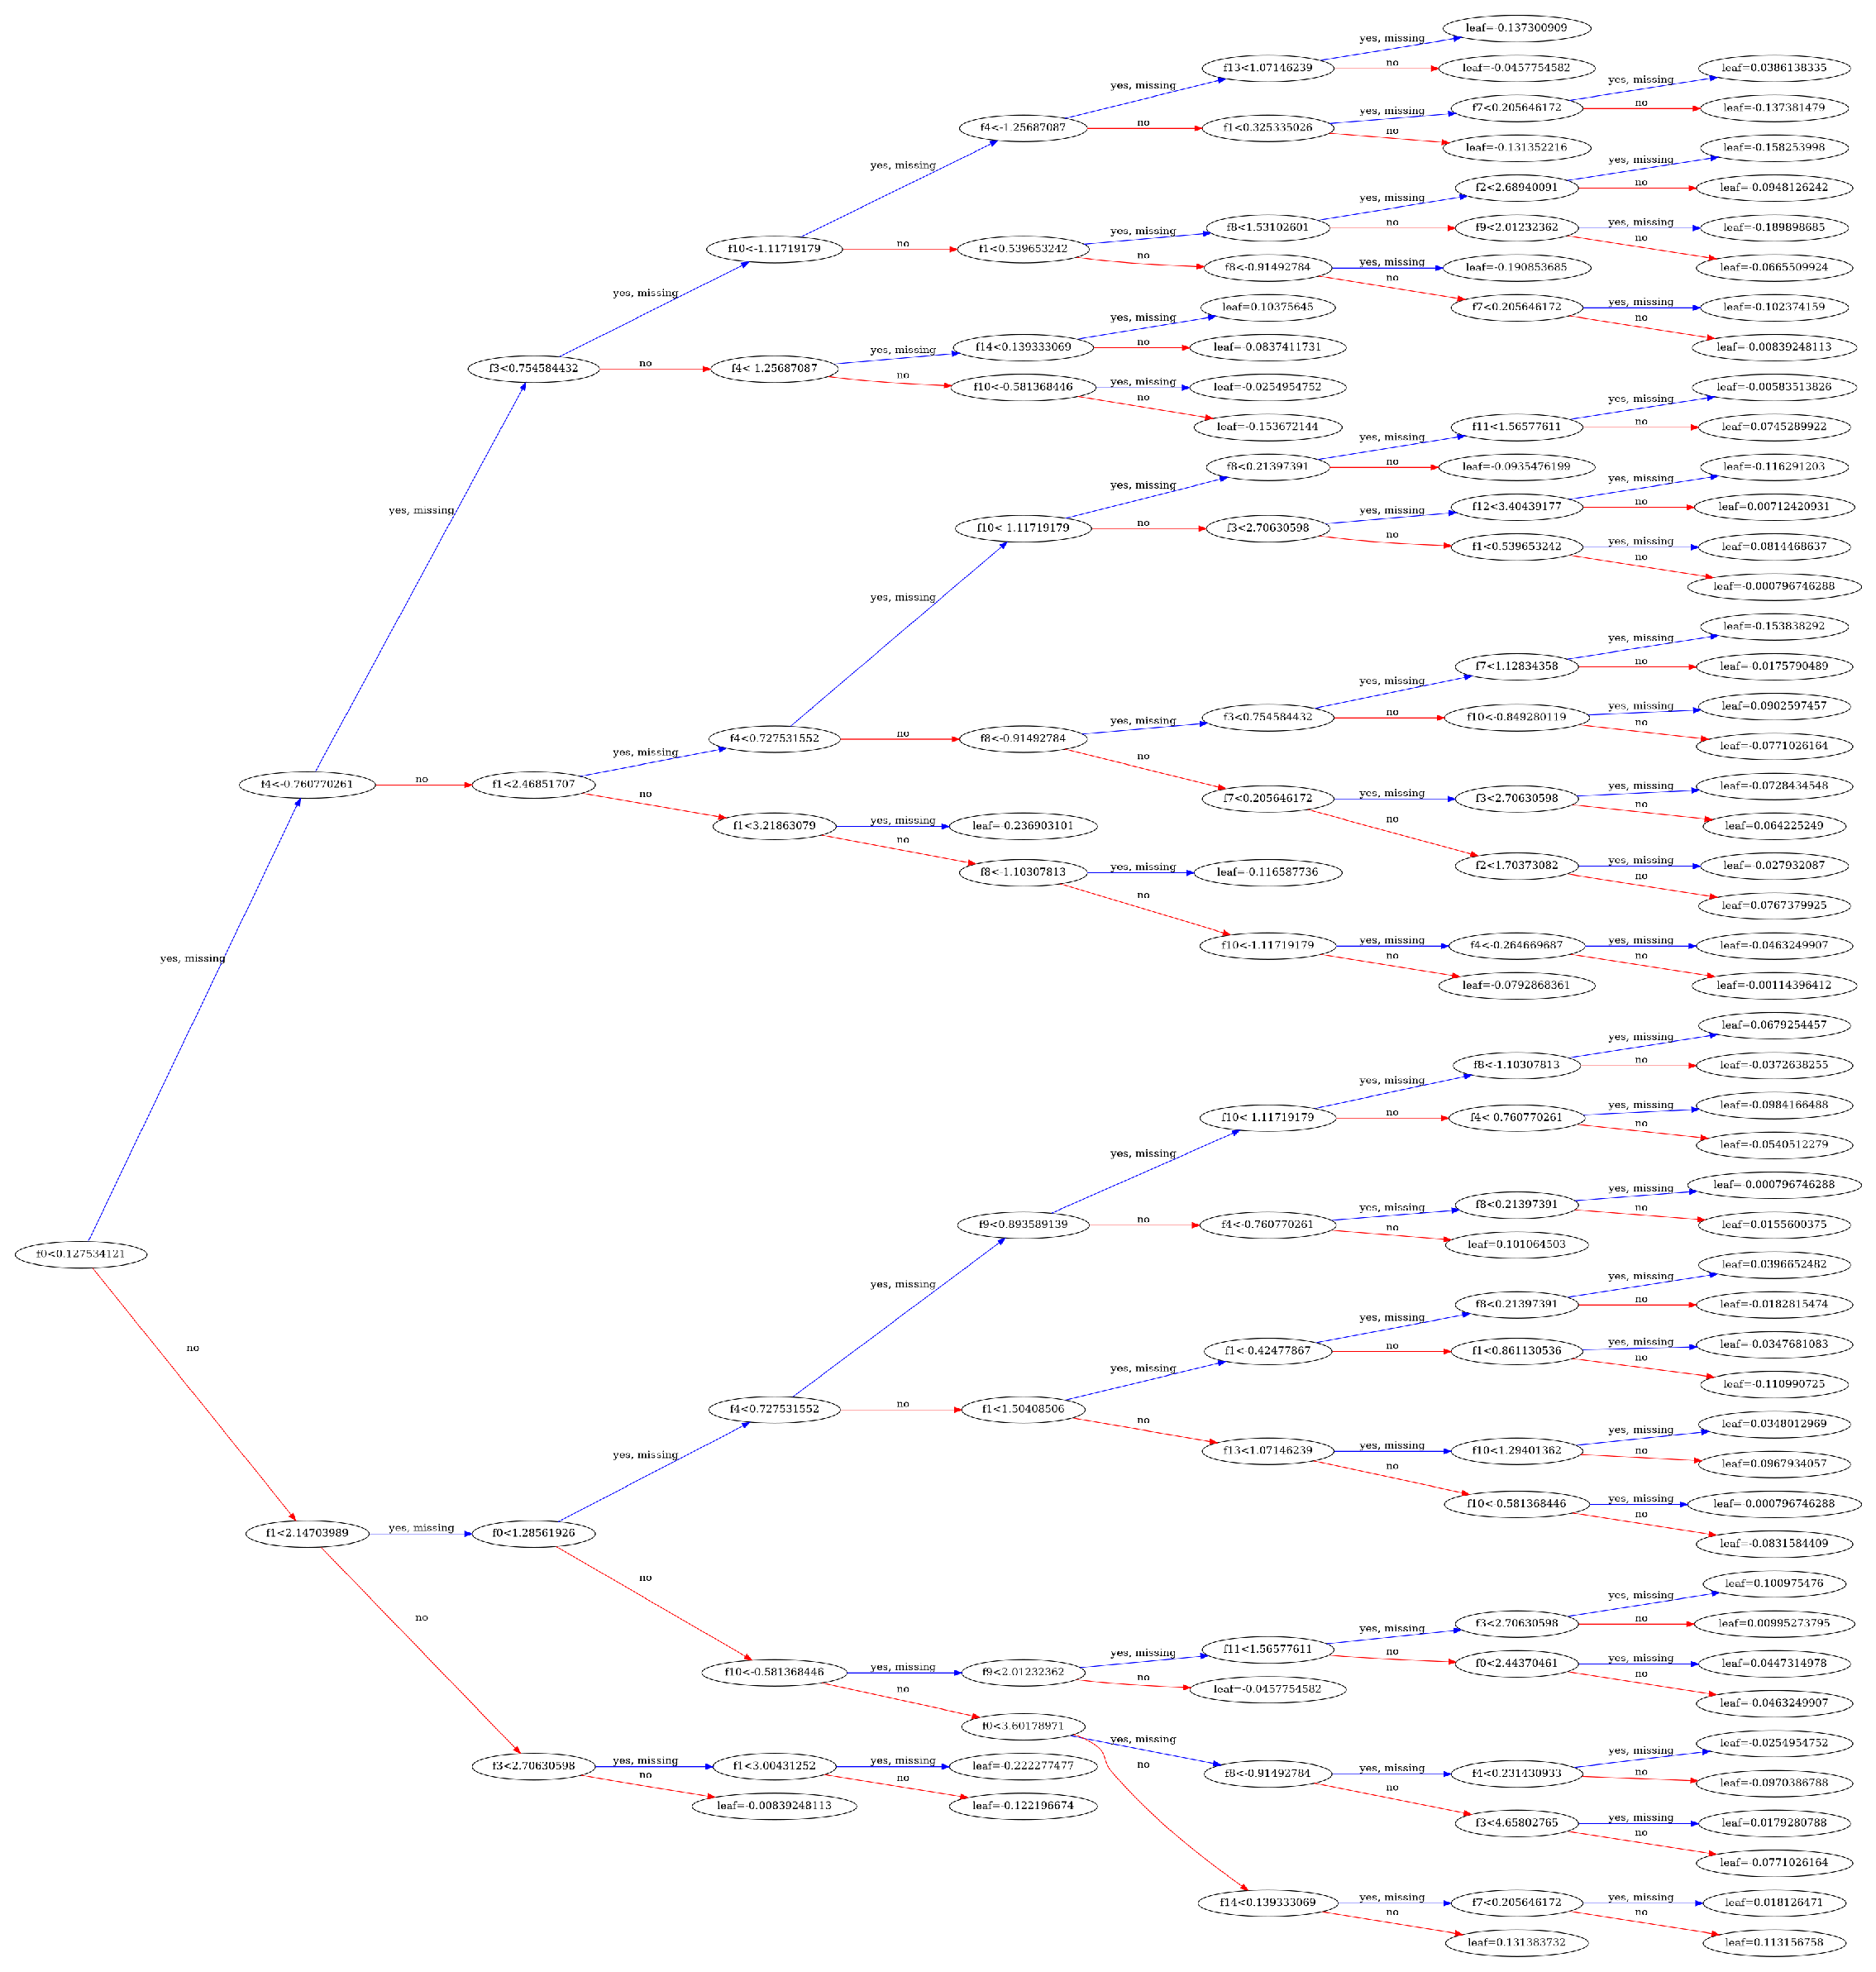

In [189]:
_, xgb_model = models[5]
xgb_model.fit(train_filtered, y_train)
fig, ax = plt.subplots(1,1,figsize=(16,16),dpi=150)
plot_tree(xgb_model, num_trees=0,rankdir='LR',ax=ax)
plt.tight_layout()

Again we take a look at the feature names:

In [195]:
_, key,_ = zip(*feat_import)
for i, k in enumerate(key[:15]):
    print(f"f{i}: {k}")

f0: number_inpatient
f1: discharge_disposition_id
f2: pioglitazone
f3: number_emergency
f4: number_diagnoses
f5: repaglinide
f6: glyburide.metformin
f7: number_outpatient
f8: admission_source_id
f9: glimepiride
f10: admission_type_id
f11: rosiglitazone
f12: glyburide
f13: glipizide
f14: change


Finally we plot embeddings of features:

In [196]:
pca = PCA(n_components=2,random_state=42)
tsne = TSNE(n_components=2,random_state=42,perplexity=30)

First for categorical / numerical features and readmission

In [197]:
X_pca = pca.fit_transform(test_filtered)
X_tsne = tsne.fit_transform(test_filtered)

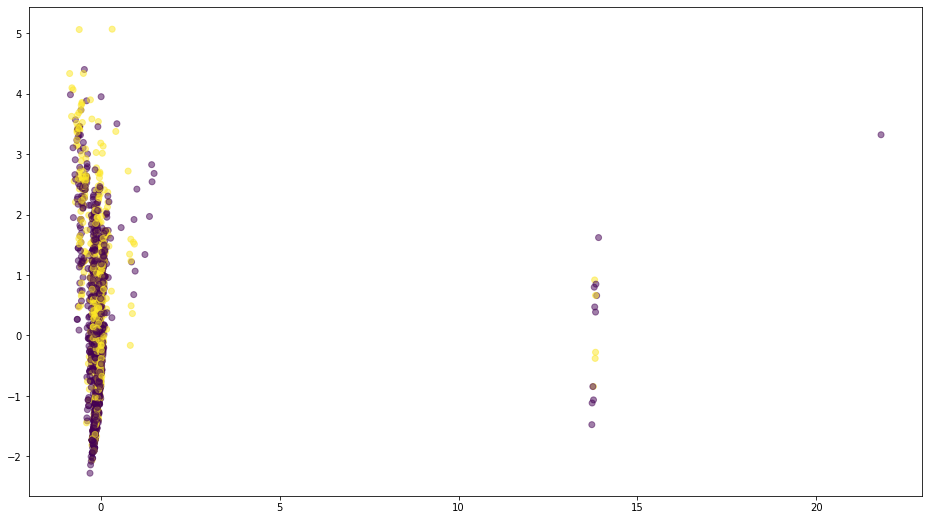

In [198]:
plt.figure(figsize=(16,9))
plt.scatter(X_pca[:,0],X_pca[:,1],alpha=0.5,c=y_test)

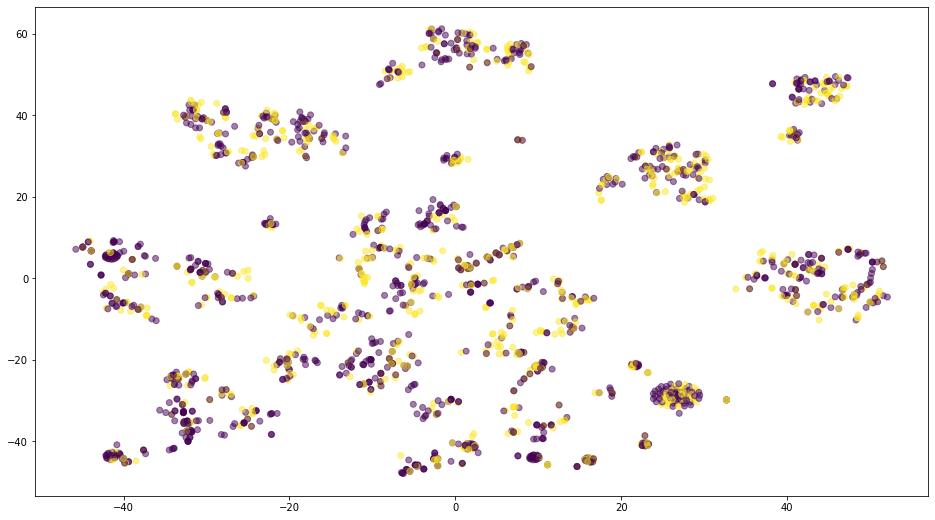

In [199]:
plt.figure(figsize=(16,9))
plt.scatter(X_tsne[:,0],X_tsne[:,1],alpha=0.5,c=y_test)

Secondly for the text features of diag_1:

In [200]:
le = LabelEncoder()
diag_1 = le.fit_transform(data['diag_1'].to_numpy()[8000:])
X_pca = pca.fit_transform(diag_filtered_test[:,:54])
X_tsne = tsne.fit_transform(diag_filtered_test[:,:54])

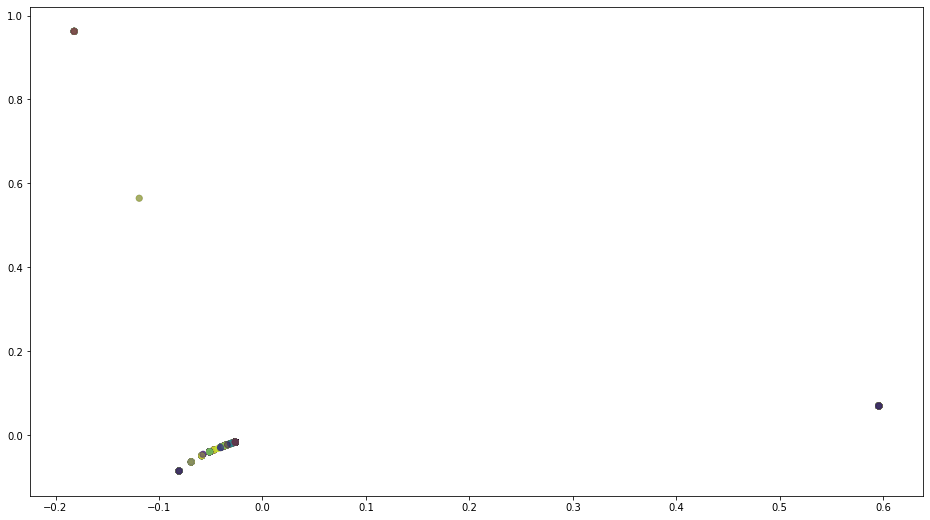

In [201]:
plt.figure(figsize=(16,9))
plt.scatter(X_pca[:,0],X_pca[:,1],alpha=0.5,c=diag_1)

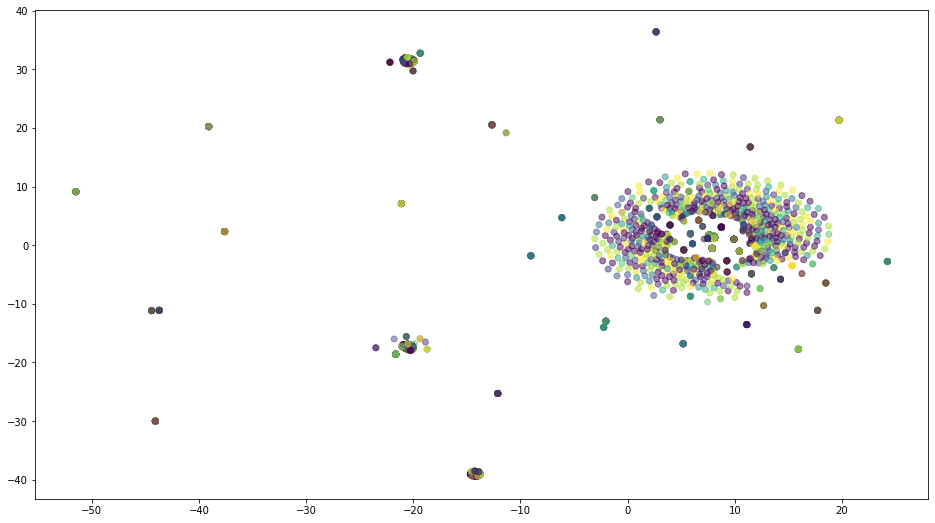

In [202]:
plt.figure(figsize=(16,9))
plt.scatter(X_tsne[:,0],X_tsne[:,1],alpha=0.5,c=diag_1)

Lastly the distributions of numerical features are plotted:

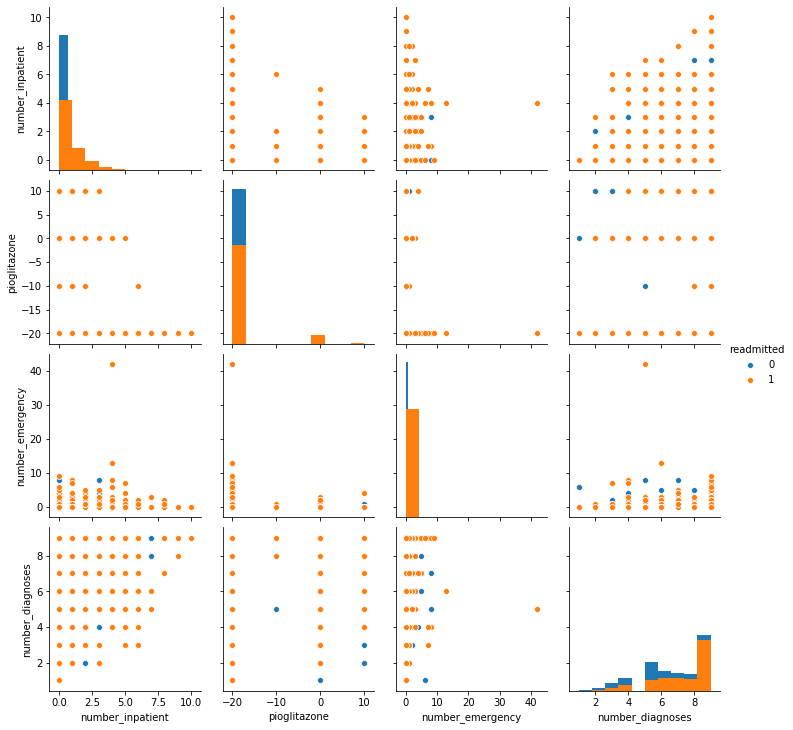

In [99]:
sns.pairplot(data[['number_inpatient','pioglitazone','number_emergency','number_diagnoses','readmitted']],diag_kind='hist',hue='readmitted')

## **Results & Discussion**  
All models using the categorical / numerical features perform better than the NIR. However not by a great margin. Since many features have low variance and conditional distributions given the readmission class are not discriminative enough more data or extensive feature engineering is needed to further improve performance. Models only using text features in form of tfidf-vectors perform generally worse than their counterparts. A possible explanation is that the text of the ICD-9 codes is the same for each code. Thus representing the codes in categorical values (e.g. ordinal-encoded or one-hot-encoded) should provide the same information. Combinations of keyword co-occurrences in the three diagnoses could hint to higher chances of readmission. However as can be seen from the results this assumption does not hold compared to non-textual features.  
From the feature importance scores extracted from the xgboost model one can see that numerical values such as the number of inpatient stays or the number of emergencies of a patient are indicators if a patient will be readmitted within the next 30 days. Categorical values such as the discharge disposition ID (to where a patient is discharged, transferred or referred after his stay) and the change in pioglitazone medication are important for readmission indication as well.  

By looking at which combination words are important one can observe that medical terms associated with heart disease ("mitral valve disorders", "heart failure") as well as other organ diseases ("acute pancreatitis", "acute kidney") play a important role to decide if a patient is likely to be readmitted within the next 30 days. The most important keyword "ketoacidosis type juvenile" hints to a potentially life-threatening complication of diabetes mellitus (<a href="https://en.wikipedia.org/wiki/Diabetic_ketoacidosis" title = "ketoacidosis">wiki</a>) in it's early stage.  
From the feature importance scores we selected a subset and trained each model again, in a last step we combined categorical / numerical with text features to investigate if the performance improves. By reducing the number of degrees of freedom in the model (i.e. reducing the number of features) we simplify the model and reduce the possibilities to overfit data. Theoretically we reduce the models variance by introducing a little more bias, resulting in a more stable estimation of performance less prone to overfitting. This behavior is the case for categorical / numerical values but interestingly not the case for the text features. From the notebook it can be seen that a large portion of the text features have little or no importance thus only inducing noise to the data. Reducing the level of noise can lead to more accurate predictions. However still no model yields a higher score than the NIR.
Combining features has little to no influence on the performance and if so only negative.  
We conclude predicting the readmission of diabetes patients from the given features is difficult. The additional provided text descriptions of ICD-9 codes do not solve this issue, but can give valuable insights which diseases indicate higher likelihood of readmission. Further we could identify specific numerical features which can be seen as important indicator for readmission.